##### NAME:- Mallangi Surya prakash Reddy
##### Student ID:- MAL22600115

### Importing Necessary libraries

In [6]:
"""
Importing necessary libraries to load audio files, generating neural network models,
plotting the audio files and graphs, diplaying the audio for live play and ziping and unziping the ziped files.
"""
import os
import torch
import shutil
import tarfile
import librosa
import random
import subprocess
import numpy as audio_np
import pandas as audio_pd
import seaborn as sns
import torch.nn as nn
import tkinter as tk
import librosa.display
import torch.optim as optim
import IPython.display as ipd
import torch.nn.functional as F
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm import tqdm
from itertools import cycle
from torchsummary import summary
from tkinter import filedialog
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Connecting to Google Drive

###### Dataset link:- https://commonvoice.mozilla.org/en/datasets
###### Colab link:- https://drive.google.com/file/d/14Yn89mrXDKYz10M8AUBLdbBet11YrWPj/view?usp=sharing
###### Dataset drive access:- https://drive.google.com/file/d/1YbGyzKmvzsW47jLQMQE8TjUMrQB9190G/view?usp=sharing

In [7]:
# Flag that will help to run the model on both local and Colab environments
try:
    # Connecting to google drive
    from google.colab import drive as gDrive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [8]:
# Mounting google drive to access the data
if not(IN_COLAB):
  print('Running the code locally.')
else:
  gDrive.mount('/content/drive')

Running the code locally.


### Setting UP the plot theme and style for Plotting Audio file

In [9]:
# Setting the plot theme for plotting the audio file
sns.set_theme(style='white', palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

### Extracting the data from .tar file and storing it in Audio processing dir

In [10]:
# Assigining path to access the dataset that contains audio files.
if not(IN_COLAB):
    zip_file_path = "cv-corpus-15.0-delta-2023-09-08-en.tar.gz"

else:
    zip_file_path = "/content/drive/MyDrive/cv-corpus-15.0-delta-2023-09-08-en.tar.gz"

# Creating a directory
extracted_tar_dir = "Audio_processing"

# Checking the existence of the directory if exists deleting the directory.
if os.path.isdir(extracted_tar_dir):
    shutil.rmtree(extracted_tar_dir)

# Creating a new and empty directory
os.makedirs(extracted_tar_dir, exist_ok=True)

# Extracting the data from the tar/ziped file
with tarfile.open(zip_file_path, 'r:gz') as tar:
    tar.extractall(extracted_tar_dir)

extracted_contents = os.listdir(extracted_tar_dir)

# Shuffle the list of extracted contents
random.shuffle(extracted_contents)

# Storing the content in the newly created directory.
for item in extracted_contents:
    source_path = os.path.join(extracted_tar_dir, item)
    destination_path = os.path.join(extracted_tar_dir, item)
    shutil.move(source_path, destination_path)

### Loading all the Audio Files

In [11]:
# Checking the environment and accessing the audio files.
if not(IN_COLAB):
    audio_files = glob('Audio_processing/cv-corpus-15.0-delta-2023-09-08/en/clips/*.mp3')
else:
    audio_files = glob('/content/Audio_processing/cv-corpus-15.0-delta-2023-09-08/en/clips/*.mp3')

In [12]:
# Checking the audio data for one file
ipd.Audio(audio_files[1])

In [13]:
# Loading a single audio file to check the content and by storing the data in y and sr variables.
y, sample_rate = librosa.load(audio_files[1])

### Plotting Auido files

#### Plotting Raw audio file

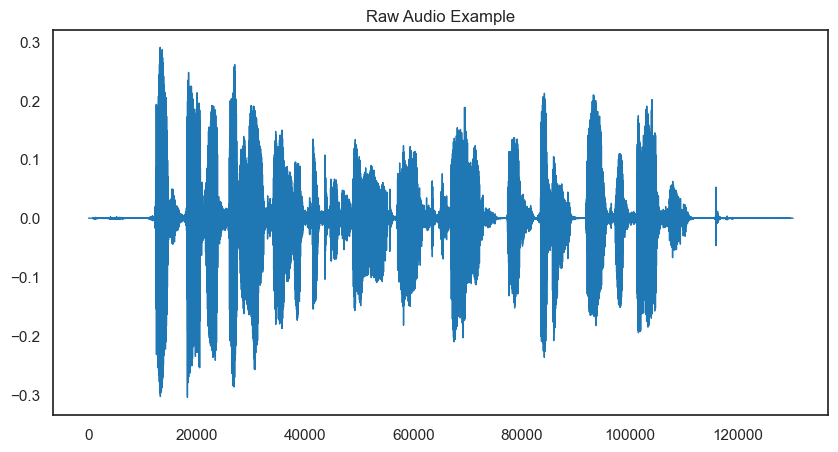

In [14]:
# Plotting the raw audio sample data for the loaded audio file.
audio_pd.Series(y).plot(figsize=(10,5),lw=1,title='Raw Audio Example',color=color_pal)
plt.show()

#### Mel spectrogram plot

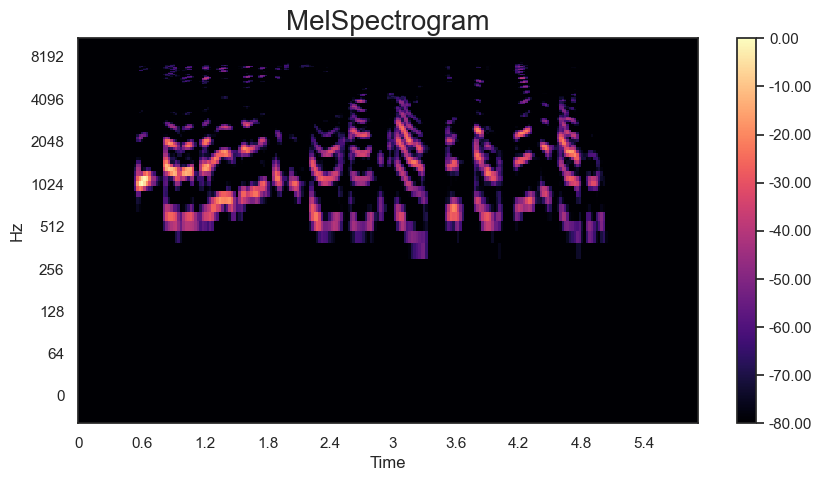

In [15]:
# Generating a spectrogram plot for the sample audio file
s = librosa.feature.melspectrogram(y=y,sr=sample_rate,n_mels=128,)
s_db_mel = librosa.amplitude_to_db(audio_np.abs(s),ref=audio_np.max)
s_db_mel.shape

fig,ax = plt.subplots(figsize=(10,5))
mel_spec_img = librosa.display.specshow(s_db_mel,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('MelSpectrogram',fontsize=20)
fig.colorbar(mel_spec_img,ax=ax,format=f'%0.2f')
plt.show()

### Reading TSV file

In [72]:
# Loading the TSV file based on evironment it will choose the path
if not(IN_COLAB):
    invalidated_file_path = "Audio_processing/cv-corpus-15.0-delta-2023-09-08/en/invalidated.tsv"
    validated_file_path = "Audio_processing/cv-corpus-15.0-delta-2023-09-08/en/validated.tsv"
    other_tsv_file_path = "Audio_processing/cv-corpus-15.0-delta-2023-09-08/en/other.tsv"
else:
    invalidated_file_path = "/content/Audio_processing/cv-corpus-15.0-delta-2023-09-08/en/invalidated.tsv"
    validated_file_path = "/content/Audio_processing/cv-corpus-15.0-delta-2023-09-08/en/validated.tsv"
    other_tsv_file_path = "/content/Audio_processing/cv-corpus-15.0-delta-2023-09-08/en/other.tsv"

# Reading the tsv files.
invalidated_data = audio_pd.read_csv(invalidated_file_path, sep='\t')
validated_data = audio_pd.read_csv(validated_file_path, sep='\t')
other_data = audio_pd.read_csv(other_tsv_file_path, sep='\t')

# Concatinating the csv files data into single dataframe.
contatenated_data = audio_pd.concat([invalidated_data, validated_data, other_data], ignore_index=True)

In [73]:
# Making a copy of the data set to preserve the original content.
audio_dataset = contatenated_data.copy()

In [74]:
audio_dataset.shape

(40571, 11)

In [75]:
audio_dataset.columns

Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accents', 'variant', 'locale', 'segment'],
      dtype='object')

### Dropping the unnecessary columns

In [76]:
# Dropping the unwanted columns that dosen't contribute much to the data.
audio_dataset = audio_dataset.drop(['client_id','up_votes','down_votes','variant',	'locale',	'segment'],axis=1)

In [77]:
audio_dataset.head()

,path,sentence,age,gender,accents
0,common_voice_en_38024781.mp3,"This cartoon has its limits, but it does provi...",thirties,female,"Southern African (South Africa, Zimbabwe, Nami..."
1,common_voice_en_38024783.mp3,"This is related to the unit of length termed ""...",thirties,female,"Southern African (South Africa, Zimbabwe, Nami..."
2,common_voice_en_38024805.mp3,The segments behind it gradually taper towards...,thirties,female,"Southern African (South Africa, Zimbabwe, Nami..."
3,common_voice_en_38024828.mp3,"Births take place in dens, usually located in ...",thirties,female,"Southern African (South Africa, Zimbabwe, Nami..."
4,common_voice_en_38025093.mp3,The Projector had a number of defects.,thirties,female,"Southern African (South Africa, Zimbabwe, Nami..."


In [78]:
audio_dataset['gender'].unique()

array(['female', 'male', 'other', nan], dtype=object)

##### Replacing NaN with no info

In [79]:
audio_dataset.fillna({'gender': 'no info', 'age': 'no info', 'accents':'United States English'}, inplace=True)

### Storing MFCC plots as images

In [27]:
# Resampling the auido file data one by one with sample rate of 16000
def resample_audio(audio_file, target_sr=16000):
    y, sr = librosa.load(audio_file, sr=None)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return y, sr

In [28]:
mel_spec_dir = "mel_spectrogram_images"

In [29]:
if os.path.isdir(mel_spec_dir):
    shutil.rmtree(mel_spec_dir)

os.makedirs(mel_spec_dir, exist_ok=True)

# Converting the audio files into mel spectrogram images
def process_audio(audio_file):
    try:
        y, sample_rate = resample_audio(audio_file)

        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_mels=128)
        mel_db = librosa.power_to_db(mel_spectrogram, ref=audio_np.max)

        # Plotting the mel spectrograms without any axis
        plt.figure(figsize=(10, 5))
        librosa.display.specshow(mel_db, sr=sample_rate, x_axis='time', y_axis='mel')
        plt.axis('off')
        plt.tight_layout()

        # saving the mel spectrogram images as .png images
        output_file = os.path.join(mel_spec_dir, os.path.basename(audio_file)[:-4] + ".png")
        plt.savefig(output_file)
        plt.close()
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")

In [30]:
processed_audio_files = 0
# Looping through the shuffled audio files and generating the spectrogram images with a limit.
for audio_file in audio_files:
    process_audio(audio_file)
    processed_audio_files += 1
    if processed_audio_files >= 5000:
        break

#### Mapping images and tsv file data

In [80]:
# removing the extentions from the path attribute from the dataframe

filenames = os.listdir(mel_spec_dir)

custom_shuffle_order = list(range(len(filenames)))
random.shuffle(custom_shuffle_order)

shuffled_filenames = [filenames[i] for i in custom_shuffle_order]

shuffled_filenames_no_ext = [os.path.splitext(filename)[0] for filename in shuffled_filenames]

audio_dataset['path_no_ext'] = audio_dataset['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

audio_dataset = audio_dataset[audio_dataset['path_no_ext'].isin(shuffled_filenames_no_ext)].reset_index(drop=True)

audio_dataset.drop(columns=['path_no_ext'], inplace=True)

#### Saving the audio file before label encoding for Web application

In [83]:
# Converting the list of dictionaries to a DataFrame
save_data = audio_pd.DataFrame(audio_dataset)

# Specifing the file path to save the CSV file
file_path = 'output.csv'

save_data.to_csv(file_path, index=False) 

#### Encoding age, accent and gender

In [84]:
le = LabelEncoder()

# Encoding age, accent and gender data
label_encoders = {}
for column in ['age', 'gender', 'accents']:
    le = LabelEncoder()
    audio_dataset[column] = le.fit_transform(audio_dataset[column])
    label_encoders[column] = le

In [85]:
audio_dataset.head()

,path,sentence,age,gender,accents
0,common_voice_en_38029640.mp3,In practice they were the pastoralist's banker.,6,0,8
1,common_voice_en_38030591.mp3,Ties are established with the Bolivarian Repub...,6,0,8
2,common_voice_en_38033863.mp3,"His father-in-law was Richard Bache, Senior a ...",5,1,7
3,common_voice_en_38038427.mp3,Little Chalfont is located southeast of Aylesb...,5,0,8
4,common_voice_en_38031373.mp3,Air interdiction missions are conducted agains...,6,0,8


In [86]:
audio_dataset.shape

(5000, 5)

### Loading and splitting of the spectrogram images

#### Loading the images

In [87]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Custom dataset class for loading images with associated labels from a DataFrame.

        Args:
            dataframe (DataFrame): DataFrame containing image filenames and labels.
            root_dir (str): Directory containing the images.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

        # List image files in the root directory
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: Total number of samples in the dataset.
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Get the sample at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image, gender label, age label, accent label, and image path.
        """
        img_name_with_extension = self.dataframe.iloc[idx, 0]  # Image filename with extension from DataFrame
        img_name, _ = os.path.splitext(img_name_with_extension)  # Split filename and extension

        img_path = None
        for filename in self.image_files:
            if img_name == os.path.splitext(filename)[0]:  # Match image filename without extension
                img_path = os.path.join(self.root_dir, filename)  # Reconstruct full image path with extension
                break

        if img_path is None:
            print(f"Image file {img_name_with_extension} not found in {self.root_dir}")
            return None

        try:
            image = Image.open(img_path).convert('RGB')  # Load image and convert to RGB
            if self.transform:
                image = self.transform(image)  # Apply transformation if specified
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None

        # Get gender, age, and accent labels from the DataFrame
        gender_label = torch.tensor(self.dataframe.iloc[idx, 3])
        age_label = torch.tensor(self.dataframe.iloc[idx, 2])
        accent_label = torch.tensor(self.dataframe.iloc[idx, 4])

        return image, gender_label, age_label, accent_label, img_path  # Returning image path along with other data

#### Splitting the images into test, train and validate

In [88]:
# Splitting the dataset into train, test, and evaluation sets
train_data, test_and_eval_data = train_test_split(audio_dataset, test_size=0.3, random_state=42)
test_data, eval_data = train_test_split(test_and_eval_data, test_size=0.3, random_state=42)

# Applying data augmentation and transforming the images into tensors
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.RandomResizedCrop(size=64, scale=(1.0, 1.1), ratio=(1.0, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating custom datasets for train, test, and evaluate sets
train_dataset = CustomDataset(dataframe=train_data, root_dir=mel_spec_dir, transform=transform)
test_dataset = CustomDataset(dataframe=test_data, root_dir=mel_spec_dir, transform=transform)
eval_dataset = CustomDataset(dataframe=eval_data, root_dir=mel_spec_dir, transform=transform)

# Creating DataLoaders for train, test, and evaluate sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

### Audio Processing Neural Network Model

#### CNN Model

In [89]:
# applying GPU instead of CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [90]:
# Creating a Multitask model that prosess age, gender, and accent data.
class MultiTaskAudioProcessing(nn.Module):
    """
    A multitask model for processing age, gender, and accent data from audio inputs.

    Attributes:
        num_gender_classes (int): Number of classes for gender classification.
        num_age_classes (int): Number of classes for age classification.
        num_accent_classes (int): Number of classes for accent classification.
    """

    def __init__(self, num_gender_classes, num_age_classes, num_accent_classes):
        """
        Initialize the MultiTaskAudioProcessing model.

        Args:
            num_gender_classes (int): Number of classes for gender classification.
            num_age_classes (int): Number of classes for age classification.
            num_accent_classes (int): Number of classes for accent classification.
        """
        super(MultiTaskAudioProcessing, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        
        # Output layers for each task
        self.fc_gender = nn.Linear(512, num_gender_classes)
        self.fc_age = nn.Linear(512, num_age_classes)
        self.fc_accent = nn.Linear(512, num_accent_classes)  # Adjusted output layer for accent classification
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        """
        Forward pass of the MultiTaskAudioProcessing model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            gender_output (torch.Tensor): Predictions for gender classification.
            age_output (torch.Tensor): Predictions for age classification.
            accent_output (torch.Tensor): Predictions for accent classification.
        """
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        # Output for each task
        gender_output = self.fc_gender(x)
        age_output = self.fc_age(x)
        accent_output = self.fc_accent(x)
        
        return gender_output, age_output, accent_output


#### Adding loss and optimizer functions

In [91]:
num_gender_classes = len(train_data['gender'].unique())
num_age_classes = len(train_data['age'].unique())
num_accent_classes = len(train_data['accents'].unique())

# assiging multi task model to a variable
multiTaskModel = MultiTaskAudioProcessing(num_gender_classes, num_age_classes, num_accent_classes)

# assiging loss to appropriate variables.
criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.CrossEntropyLoss()
criterion_accent = nn.CrossEntropyLoss()

# Intalizing the adam optimizer with model parameters and learnining rate of 0.001
optimizer = optim.Adam(multiTaskModel.parameters(), lr=0.001)

In [92]:
# Print the summary of the model
summary(multiTaskModel, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
         MaxPool2d-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         295,168
      BatchNorm2d-10          [-1, 256, 16, 16]             512
             ReLU-11          [-1, 256, 16, 16]               0
        MaxPool2d-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 8, 8]       1,180,160
      BatchNorm2d-14            [-1, 51

#### Genrating the train model

In [93]:
# Setting up number of epochs
num_epochs = 10

In [94]:
def train_multi_task(MTLModel, train_loader, criterion_gender, criterion_age, criterion_accent, optimizer, device, num_epochs):
    """
    Function to train a multitask model.

    Args:
        MTLModel (torch.nn.Module): Multitask model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        criterion_gender: Criterion for gender classification loss.
        criterion_age: Criterion for age classification loss.
        criterion_accent: Criterion for accent classification loss.
        optimizer: Optimizer for updating model parameters.
        device (torch.device): Device to perform training on (e.g., 'cuda' or 'cpu').
        num_epochs (int): Number of epochs for training.

    Returns:
        gender_losses (list): List of gender losses for each epoch.
        age_losses (list): List of age losses for each epoch.
        accent_losses (list): List of accent losses for each epoch.
        gender_accuracies (list): List of gender accuracies for each epoch.
        age_accuracies (list): List of age accuracies for each epoch.
        accent_accuracies (list): List of accent accuracies for each epoch.
        average_losses (list): List of average losses for each epoch.
        average_accuracies (list): List of average accuracies for each epoch.
    """
    MTLModel.train()
    MTLModel.to(device)

    gender_losses = []
    age_losses = []
    accent_losses = []

    gender_accuracies = []
    age_accuracies = []
    accent_accuracies = []

    average_losses = []
    average_accuracies = []

    for epoch in range(num_epochs):
        running_gender_loss = 0.0
        running_age_loss = 0.0
        running_accent_loss = 0.0

        correct_gender_predictions = 0
        correct_age_predictions = 0
        correct_accent_predictions = 0

        total_predictions = 0
        

        for images, gender_labels, age_labels, accent_labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            images, gender_labels, age_labels, accent_labels = images.to(device), gender_labels.to(device), age_labels.to(device), accent_labels.to(device)

            optimizer.zero_grad()

            gender_output, age_output, accent_output = MTLModel(images)

            gender_loss = criterion_gender(gender_output, gender_labels.type(torch.LongTensor))
            age_loss = criterion_age(age_output, age_labels.type(torch.LongTensor))

            # Remap accent labels to fall within the range of 0 to 64
            accent_labels_remap = torch.clamp(accent_labels, 0, 64)

            if torch.min(accent_labels_remap) >= 0 and torch.max(accent_labels_remap) < num_accent_classes:
                accent_loss = criterion_accent(accent_output, accent_labels_remap.type(torch.LongTensor))
            else:
                # Handle invalid accent labels
                print("Invalid accent labels detected.")
                continue

            loss = gender_loss + age_loss + accent_loss
            loss.backward()
            optimizer.step()

            running_gender_loss += gender_loss.item() * images.size(0)
            running_age_loss += age_loss.item() * images.size(0)
            running_accent_loss += accent_loss.item() * images.size(0)

            _, predicted_gender = torch.max(gender_output, 1)
            _, predicted_age = torch.max(age_output, 1)
            _, predicted_accent = torch.max(accent_output, 1)

            correct_gender_predictions += (predicted_gender == gender_labels).sum().item()
            correct_age_predictions += (predicted_age == age_labels).sum().item()
            correct_accent_predictions += (predicted_accent == accent_labels).sum().item()

            total_predictions += gender_labels.size(0)

        epoch_gender_loss = running_gender_loss / len(train_loader.dataset)
        epoch_age_loss = running_age_loss / len(train_loader.dataset)
        epoch_accent_loss = running_accent_loss / len(train_loader.dataset)

        epoch_gender_accuracy = correct_gender_predictions / total_predictions
        epoch_age_accuracy = correct_age_predictions / total_predictions
        epoch_accent_accuracy = correct_accent_predictions / total_predictions

        # print(f"Epoch {epoch+1}/{num_epochs}, Gender Loss: {epoch_gender_loss:.4f}, Age Loss: {epoch_age_loss:.4f}, Accent Loss: {epoch_accent_loss:.4f}, Gender Accuracy: {epoch_gender_accuracy:.4f}, Age Accuracy: {epoch_age_accuracy:.4f}, Accent Accuracy: {epoch_accent_accuracy:.4f}")
        # Append epoch-level losses and accuracies to lists
        gender_losses.append(epoch_gender_loss)
        age_losses.append(epoch_age_loss)
        accent_losses.append(epoch_accent_loss)

        gender_accuracies.append(epoch_gender_accuracy)
        age_accuracies.append(epoch_age_accuracy)
        accent_accuracies.append(epoch_accent_accuracy)

        # Calculate average loss and accuracy
        average_loss = (epoch_gender_loss + epoch_age_loss + epoch_accent_loss) / 3
        average_accuracy = (epoch_gender_accuracy + epoch_age_accuracy + epoch_accent_accuracy) / 3

        print(f"Epoch {epoch+1}/{num_epochs}, average Loss: {average_loss:.4f}, average Accuracy: {average_accuracy:.4f}")

        average_losses.append(average_loss)
        average_accuracies.append(average_accuracy)

    # Return lists of losses and accuracies for each task, as well as average losses and accuracies
    return gender_losses, age_losses, accent_losses, gender_accuracies, age_accuracies, accent_accuracies, average_losses, average_accuracies


In [95]:
gender_losses, age_losses, accent_losses, gender_accuracies, age_accuracies, accent_accuracies, average_losses, average_accuracies = train_multi_task(multiTaskModel, train_loader, criterion_gender, criterion_age, criterion_accent, optimizer, device, num_epochs)

Epoch 1/10: 100%|██████████| 55/55 [01:37<00:00,  1.78s/batch]


Epoch 1/10, average Loss: 0.9062, average Accuracy: 0.6895


Epoch 2/10: 100%|██████████| 55/55 [01:29<00:00,  1.62s/batch]


Epoch 2/10, average Loss: 0.4289, average Accuracy: 0.8534


Epoch 3/10: 100%|██████████| 55/55 [01:28<00:00,  1.62s/batch]


Epoch 3/10, average Loss: 0.3098, average Accuracy: 0.9008


Epoch 4/10: 100%|██████████| 55/55 [01:34<00:00,  1.71s/batch]


Epoch 4/10, average Loss: 0.2308, average Accuracy: 0.9265


Epoch 5/10: 100%|██████████| 55/55 [01:32<00:00,  1.68s/batch]


Epoch 5/10, average Loss: 0.1940, average Accuracy: 0.9392


Epoch 6/10: 100%|██████████| 55/55 [01:34<00:00,  1.71s/batch]


Epoch 6/10, average Loss: 0.1674, average Accuracy: 0.9471


Epoch 7/10: 100%|██████████| 55/55 [01:30<00:00,  1.65s/batch]


Epoch 7/10, average Loss: 0.1347, average Accuracy: 0.9534


Epoch 8/10: 100%|██████████| 55/55 [01:38<00:00,  1.79s/batch]


Epoch 8/10, average Loss: 0.1217, average Accuracy: 0.9592


Epoch 9/10: 100%|██████████| 55/55 [01:32<00:00,  1.68s/batch]


Epoch 9/10, average Loss: 0.1147, average Accuracy: 0.9598


Epoch 10/10: 100%|██████████| 55/55 [01:28<00:00,  1.60s/batch]

Epoch 10/10, average Loss: 0.1024, average Accuracy: 0.9656


In [96]:
torch.save(multiTaskModel.state_dict(), 'multitask_model.pth')

##### Plotting accuracy and loss of individual node

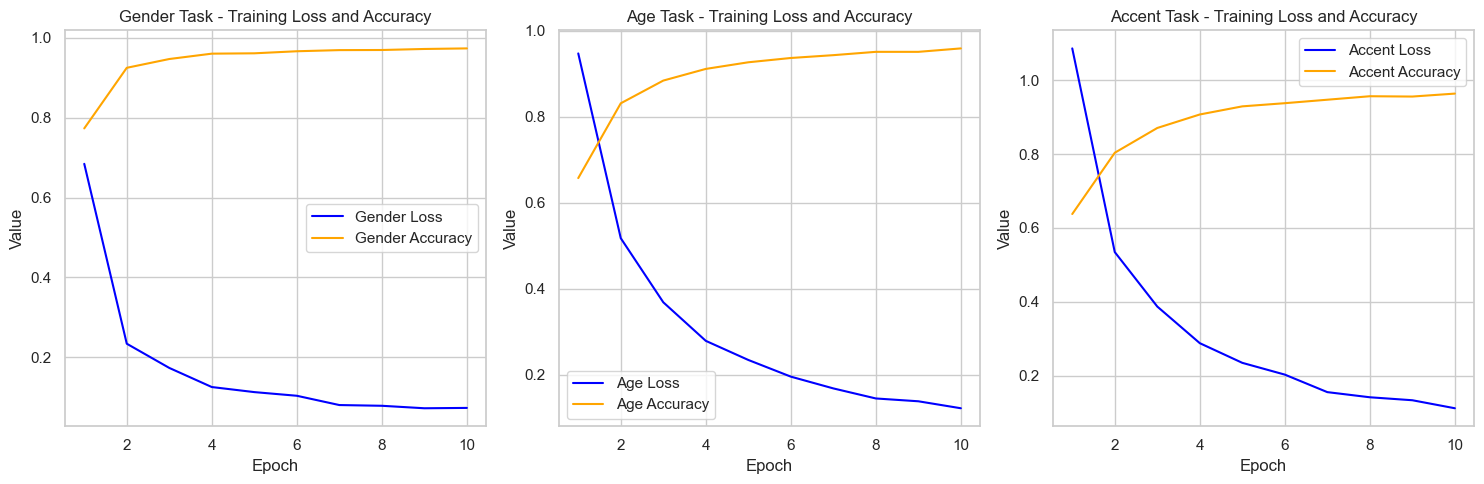

In [97]:
# Setting Seaborn style
sns.set(style="whitegrid")

# Plotting training loss and accuracy for all tasks
plt.figure(figsize=(15, 5))

# Plotting gender task
plt.subplot(1, 3, 1)
sns.lineplot(x=range(1, num_epochs + 1), y=gender_losses, label='Gender Loss', color='blue')
sns.lineplot(x=range(1, num_epochs + 1), y=gender_accuracies, label='Gender Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Gender Task - Training Loss and Accuracy')

# Plotting age task
plt.subplot(1, 3, 2)
sns.lineplot(x=range(1, num_epochs + 1), y=age_losses, label='Age Loss', color='blue')
sns.lineplot(x=range(1, num_epochs + 1), y=age_accuracies, label='Age Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Age Task - Training Loss and Accuracy')

# Plotting accent task
plt.subplot(1, 3, 3)
sns.lineplot(x=range(1, num_epochs + 1), y=accent_losses, label='Accent Loss', color='blue')
sns.lineplot(x=range(1, num_epochs + 1), y=accent_accuracies, label='Accent Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accent Task - Training Loss and Accuracy')

plt.tight_layout()
plt.show()

### Plotting average loss and accuracy of the whole model

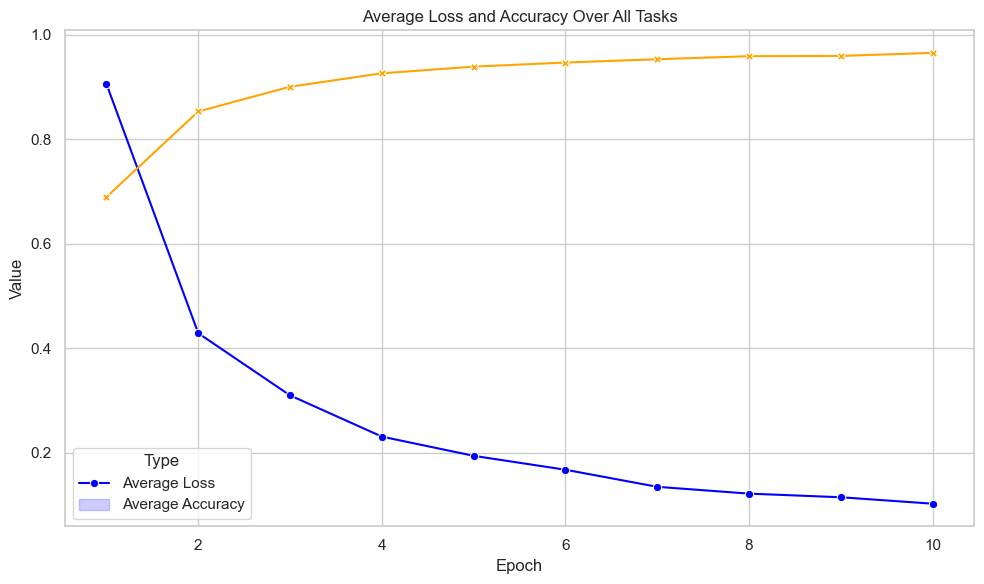

In [98]:
# Create a DataFrame to hold the epoch, average loss, and average accuracy data
data = {
    'Epoch': range(1, num_epochs + 1),
    'Average Loss': average_losses,
    'Average Accuracy': average_accuracies
}
df = audio_pd.DataFrame(data)

# Melt the DataFrame to have "type" and "value" columns, suitable for sns.lineplot
df_melted = df.melt('Epoch', var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))

# Use Seaborn's lineplot to draw average loss and accuracy
sns.lineplot(data=df_melted, x='Epoch', y='Value', hue='Type', style='Type', markers=True, dashes=False, palette=['blue', 'orange'])

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Average Loss and Accuracy Over All Tasks')

plt.legend(title='Type', labels=['Average Loss', 'Average Accuracy'])
plt.tight_layout()
plt.show()

### Evaluating data with evaluation data

In [99]:
def evaluate_multi_task(MTLModel, eval_loader, criterion_gender, criterion_age, criterion_accent, device):
    """
    Evaluate a multitask model.

    Args:
        MTLModel (torch.nn.Module): Multitask model to be evaluated.
        eval_loader (torch.utils.data.DataLoader): DataLoader for evaluation data.
        criterion_gender: Criterion for gender classification loss.
        criterion_age: Criterion for age classification loss.
        criterion_accent: Criterion for accent classification loss.
        device (torch.device): Device to perform evaluation on (e.g., 'cuda' or 'cpu').

    Returns:
        eval_gender_loss (float): Gender classification loss.
        eval_age_loss (float): Age classification loss.
        eval_accent_loss (float): Accent classification loss.
        eval_gender_accuracy (float): Gender classification accuracy.
        eval_age_accuracy (float): Age classification accuracy.
        eval_accent_accuracy (float): Accent classification accuracy.
    """
    # Set the model to evaluation mode
    MTLModel.eval()
    # Move the model to the specified device
    MTLModel.to(device)

    # Initialize variables to track loss and accuracy for each task
    running_gender_loss = 0.0
    running_age_loss = 0.0
    running_accent_loss = 0.0

    correct_gender_predictions = 0
    correct_age_predictions = 0
    correct_accent_predictions = 0

    total_predictions = 0

    # Disable gradient calculation since we are in evaluation mode
    with torch.no_grad():
        # Iterate over the batches in the evaluation data loader
        for batch in tqdm(eval_loader, desc="Evaluation", unit="batch"):
            images, gender_labels, age_labels, accent_labels, _ = batch
            # Move images and labels to the specified device
            images = images.to(device)
            gender_labels = gender_labels.to(device)
            age_labels = age_labels.to(device)
            accent_labels = accent_labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            gender_output, age_output, accent_output = MTLModel(images)

            # Compute losses for each task
            gender_loss = criterion_gender(gender_output, gender_labels.type(torch.LongTensor))
            age_loss = criterion_age(age_output, age_labels.type(torch.LongTensor))

            
            # Remap accent labels to fall within the range of 0 to 64
            accent_labels_remap = torch.clamp(accent_labels, 0, 64)

            if torch.min(accent_labels_remap) >= 0 and torch.max(accent_labels_remap) < num_accent_classes:
                accent_loss = criterion_accent(accent_output, accent_labels_remap.type(torch.LongTensor))
            else:
                # Handle invalid accent labels
                print("Invalid accent labels detected.")
                continue

            # Update running losses
            running_gender_loss += gender_loss.item() * images.size(0)
            running_age_loss += age_loss.item() * images.size(0)
            running_accent_loss += accent_loss.item() * images.size(0)

            # Calculate the number of correct predictions for each task in the current batch
            _, predicted_gender = torch.max(gender_output, 1)
            _, predicted_age = torch.max(age_output, 1)
            _, predicted_accent = torch.max(accent_output, 1)

            correct_gender_predictions += (predicted_gender == gender_labels).sum().item()
            correct_age_predictions += (predicted_age == age_labels).sum().item()
            correct_accent_predictions += (predicted_accent == accent_labels).sum().item()

            total_predictions += gender_labels.size(0)

    # Calculate average losses and accuracies for each task
    eval_gender_loss = running_gender_loss / len(eval_loader.dataset)
    eval_age_loss = running_age_loss / len(eval_loader.dataset)
    eval_accent_loss = running_accent_loss / len(eval_loader.dataset)

    eval_gender_accuracy = correct_gender_predictions / total_predictions
    eval_age_accuracy = correct_age_predictions / total_predictions
    eval_accent_accuracy = correct_accent_predictions / total_predictions

    # Print evaluation statistics
    print(f"Evaluation - Gender Loss: {eval_gender_loss:.4f}, Age Loss: {eval_age_loss:.4f}, Accent Loss: {eval_accent_loss:.4f}, Gender Accuracy: {eval_gender_accuracy:.4f}, Age Accuracy: {eval_age_accuracy:.4f}, Accent Accuracy: {eval_accent_accuracy:.4f}")

    # Return evaluation losses and accuracies
    return eval_gender_loss, eval_age_loss, eval_accent_loss, eval_gender_accuracy, eval_age_accuracy, eval_accent_accuracy


#### Plotting the evaluation loss and accuracy

Evaluation: 100%|██████████| 8/8 [00:09<00:00,  1.15s/batch]


Evaluation - Gender Loss: 0.0837, Age Loss: 0.1413, Accent Loss: 0.2156, Gender Accuracy: 0.9711, Age Accuracy: 0.9511, Accent Accuracy: 0.9400


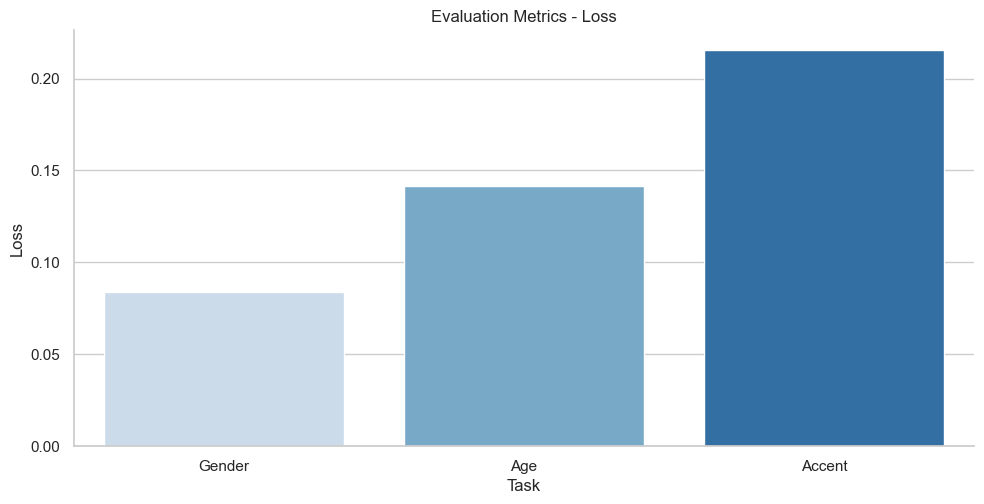

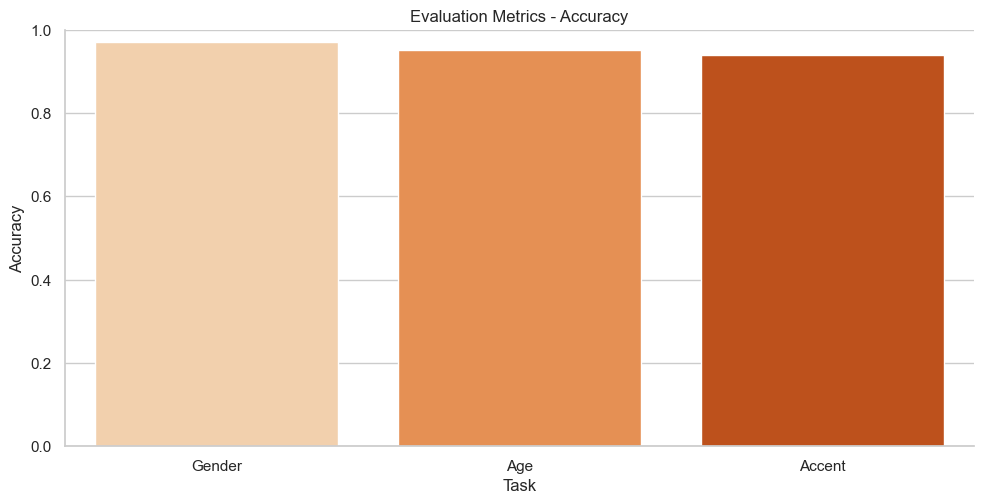

In [100]:
# Calling the evaluate_multi_task function to get the evaluation metrics
eval_gender_loss, eval_age_loss, eval_accent_loss, eval_gender_accuracy, eval_age_accuracy, eval_accent_accuracy = evaluate_multi_task(multiTaskModel, eval_loader, criterion_gender, criterion_age, criterion_accent, device)

# Creating a DataFrame to hold the evaluation metrics results
data = {
    'Task': ['Gender', 'Age', 'Accent'],
    'Loss': [eval_gender_loss, eval_age_loss, eval_accent_loss],
    'Accuracy': [eval_gender_accuracy, eval_age_accuracy, eval_accent_accuracy]
}
df = audio_pd.DataFrame(data)

# Plotting evaluation accuracy and loss using Seaborn's catplot
sns.catplot(data=df, kind='bar', x='Task', y='Loss', hue='Task', palette='Blues', height=5, aspect=2, legend=False)
plt.title('Evaluation Metrics - Loss')
plt.ylabel('Loss')
plt.show()

sns.catplot(data=df, kind='bar', x='Task', y='Accuracy', hue='Task', palette='Oranges', height=5, aspect=2, legend=False)
plt.title('Evaluation Metrics - Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

### Visualizing the test data

In [101]:
def visualize_predictions(images, gender_labels, age_labels, accent_labels, gender_predictions, age_predictions, accent_predictions, label_encoders):
    """
    Visualize predictions along with ground truth labels for a batch of images.

    Args:
        images (torch.Tensor): Batch of images.
        gender_labels (torch.Tensor): Ground truth gender labels.
        age_labels (torch.Tensor): Ground truth age labels.
        accent_labels (torch.Tensor): Ground truth accent labels.
        gender_predictions (torch.Tensor): Predicted gender labels.
        age_predictions (torch.Tensor): Predicted age labels.
        accent_predictions (torch.Tensor): Predicted accent labels.
        label_encoders (dict): Dictionary containing label encoders for each task.
    """
    # Denormalizing the images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images = images * std + mean

    # Converting images and labels to NumPy arrays
    images = images.cpu().numpy()
    gender_labels = gender_labels.cpu().numpy()
    age_labels = age_labels.cpu().numpy()
    accent_labels = accent_labels.cpu().numpy()
    gender_predictions = gender_predictions.cpu().numpy()
    age_predictions = age_predictions.cpu().numpy()
    accent_predictions = accent_predictions.cpu().numpy()

    # Iterate over the random five images in the batch
    for i in range(10):
        # Get the image
        image = images[i].transpose(1, 2, 0)

        # ground truth labels
        gender_label = label_encoders['gender'].inverse_transform([gender_labels[i]])[0]
        age_label = label_encoders['age'].inverse_transform([age_labels[i]])[0]
        accent_label = label_encoders['accents'].inverse_transform([accent_labels[i]])[0]

        # predicted labels
        gender_prediction = label_encoders['gender'].inverse_transform([gender_predictions[i]])[0]
        age_prediction = label_encoders['age'].inverse_transform([age_predictions[i]])[0]
        accent_prediction = label_encoders['accents'].inverse_transform([accent_predictions[i]])[0]

        # Displaying the image with labels
        plt.imshow(image)
        plt.title(f"Ground Truth: Gender - {gender_label}, Age - {age_label}, Accent - {accent_label}\n"
                  f"Prediction: Gender - {gender_prediction}, Age - {age_prediction}, Accent - {accent_prediction}")
        plt.axis('off')
        plt.show()

In [102]:
# batch of data from the test loader data
images, gender_labels, age_labels, accent_labels, _ = next(iter(test_loader))

# Moving the data to the device
images = images.to(device)
gender_labels = gender_labels.to(device)
age_labels = age_labels.to(device)
accent_labels = accent_labels.to(device)

# making a forward pass: computing the predicted outputs by passing inputs to the model
gender_output, age_output, accent_output = multiTaskModel(images)

# predicted labels
_, gender_predictions = torch.max(gender_output, 1)
_, age_predictions = torch.max(age_output, 1)
_, accent_predictions = torch.max(accent_output, 1)

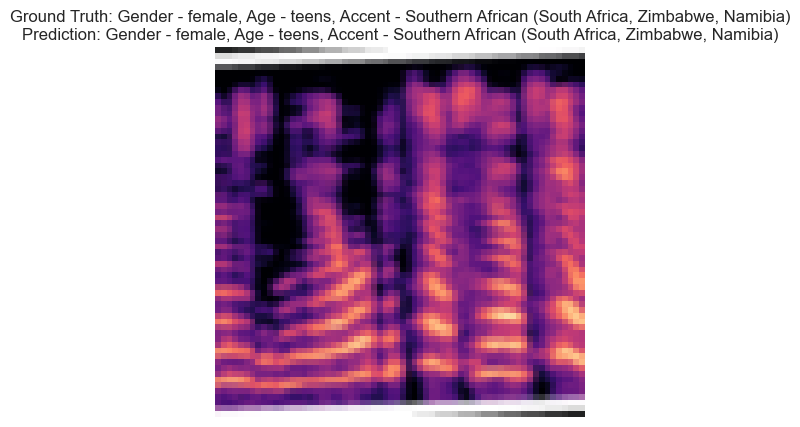

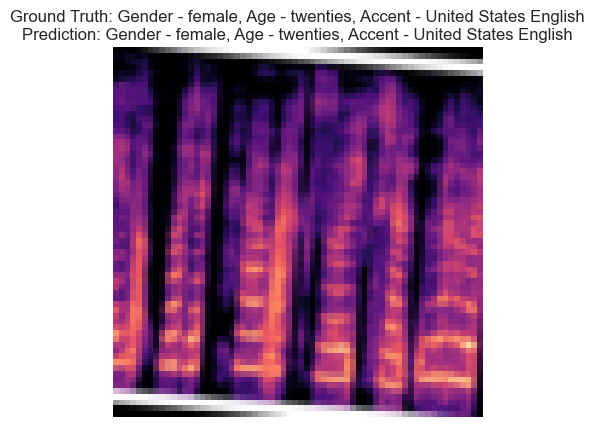

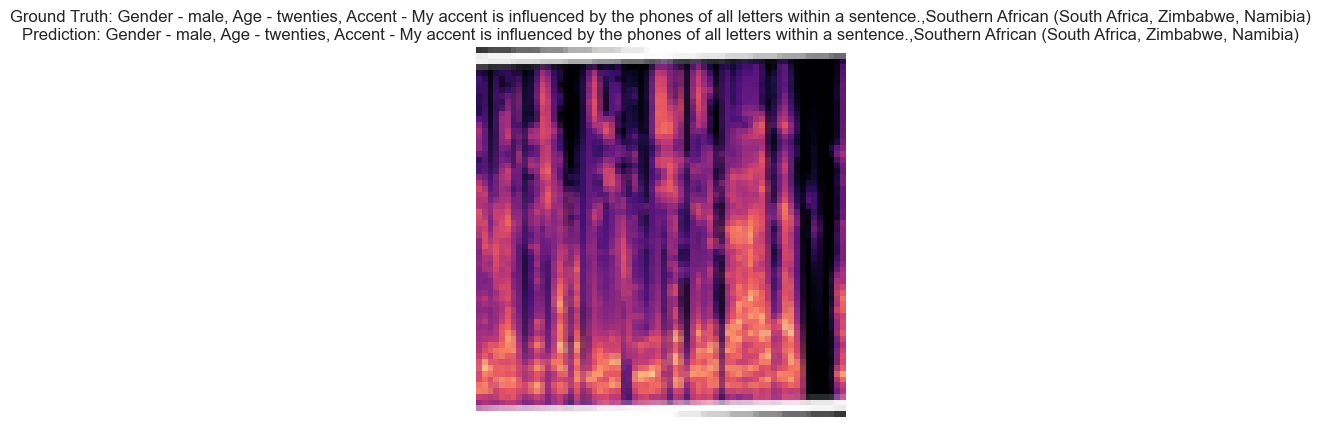

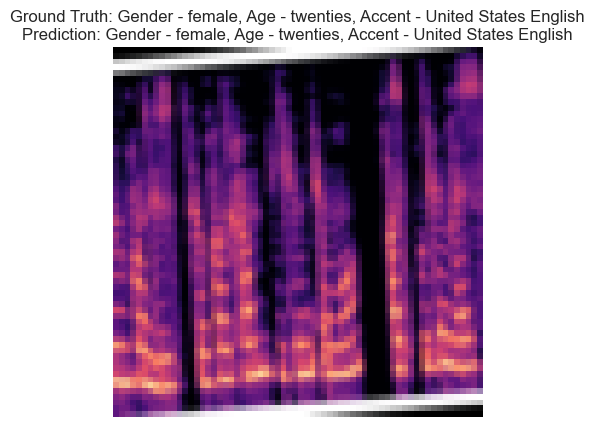

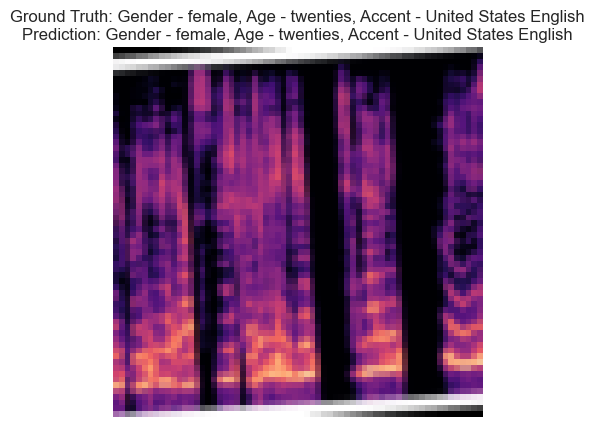

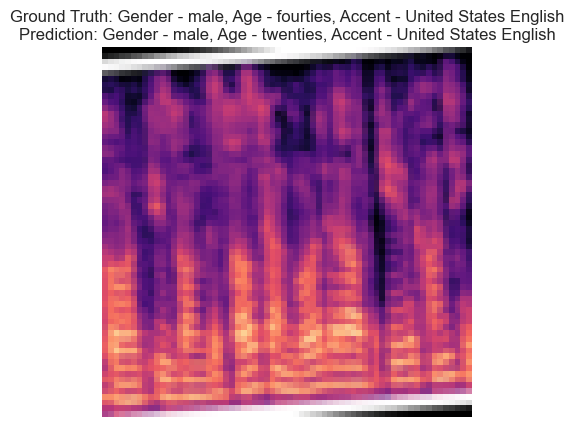

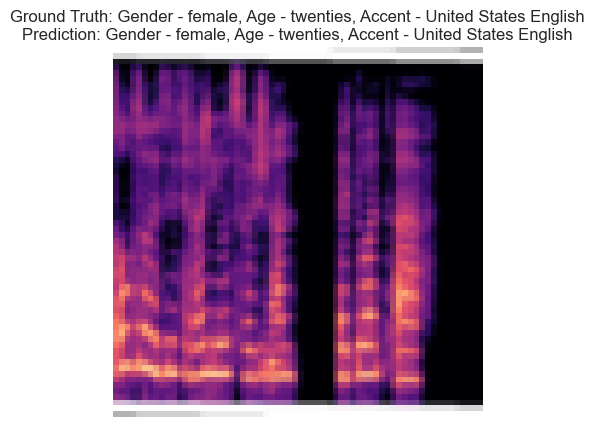

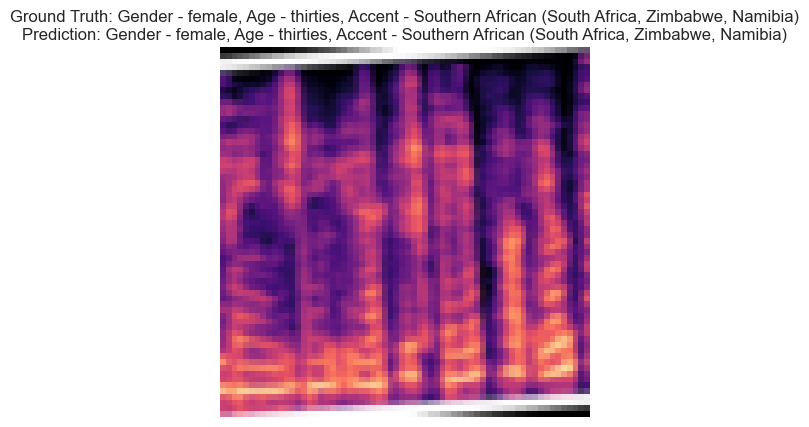

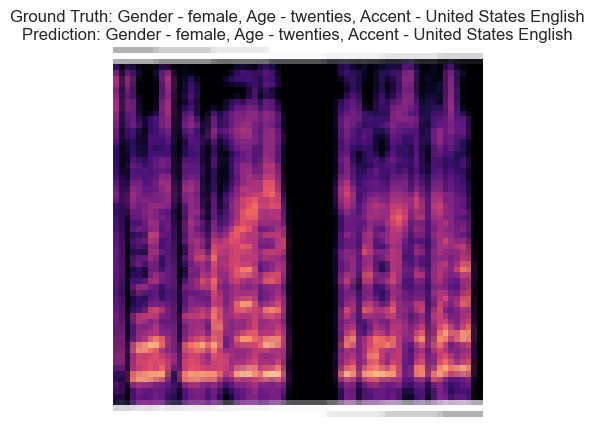

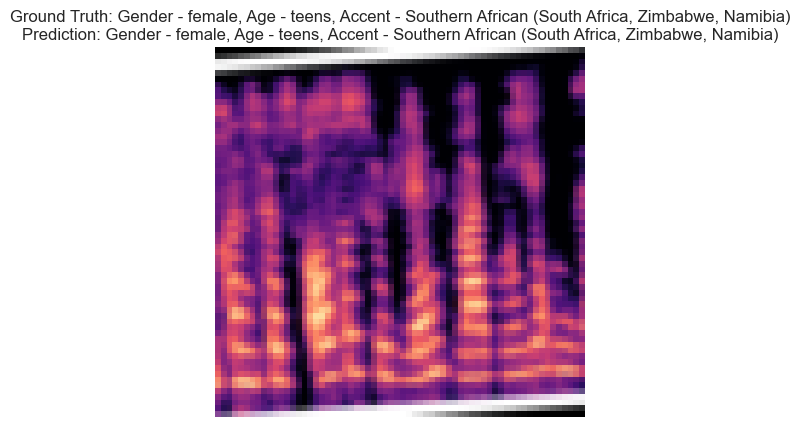

In [103]:
# Visualizing the sample test predictions
visualize_predictions(images, gender_labels, age_labels, accent_labels, gender_predictions, age_predictions, accent_predictions, label_encoders)

### Prediction of the audio files

#### Reading audio new file and genrating spectrogram images

In [104]:
def test_preprocess_audio(audio_file_path):
    """
    Preprocess audio file for testing with a model.

    Args:
        audio_file_path (str): Path to the audio file.

    Returns:
        torch.Tensor: Preprocessed Mel spectrogram tensor.
    """
    # Loading the audio file
    y, sr = librosa.load(audio_file_path, sr=16000)

    # Extracting the audio features (e.g., Mel spectrograms)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=audio_np.max(mel_spec))

    # Normalizeing the spectrogram
    mel_spec_normalized = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

    # Convertint the normalized spectrogram to PIL Image
    mel_spec_image = Image.fromarray((mel_spec_normalized * 255).astype(audio_np.uint8))

    # Converting the normal image to grayscale
    mel_spec_image = mel_spec_image.convert('RGB')

    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomResizedCrop(size=64, scale=(1.0, 1.1), ratio=(1.0, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    mel_spec_tensor = transform(mel_spec_image)

    # Adding batch dimension
    mel_spec_tensor = mel_spec_tensor.unsqueeze(0)

    return mel_spec_tensor

#### Predicting the new audio file in a interactive way

In [105]:
def select_file_and_predict():
    """
    Function to handle file selection, preprocess audio, and make predictions.
    """
    # Opening the file dialog to select audio file
    audio_file_path = filedialog.askopenfilename(initialdir="/", title="Select Audio File",
                                                  filetypes=(("MP3 Files", "*.mp3"), ("All Files", "*.*")))

    if not audio_file_path:
        # if nothing is selected, the returns none
        return

    # Preprocesses the audio file
    mel_spec_tensor = test_preprocess_audio(audio_file_path)

    # Makes the predictions by passing the unseen audio file to the model
    with torch.no_grad():
        gender_output, age_output, accent_output = multiTaskModel(mel_spec_tensor)

    # Decodes the predictions
    # Decoding the label encoded information of gender, age, and accent
    gender_prediction = label_encoders['gender'].inverse_transform([torch.argmax(gender_output).item()])[0]
    age_prediction = label_encoders['age'].inverse_transform([torch.argmax(age_output).item()])[0]
    accent_prediction = label_encoders['accents'].inverse_transform([torch.argmax(accent_output).item()])[0]

    # Displays predictions on the GUI
    prediction_text.set(f"Predicted Gender: {gender_prediction}\nPredicted Age: {age_prediction}\nPredicted Accent: {accent_prediction}")

    # Printing the predictions in the output window
    print(f"Predicted Gender: {gender_prediction}")
    print(f"Predicted Age: {age_prediction}")
    print(f"Predicted Accent: {accent_prediction}")

# Createing a Tkinter GUI
# User can select the audio file on his own but it needs to be in the from of .mp3
root = tk.Tk()
root.title("Audio Prediction")

# Creating label for displaying predictions on the GUI
prediction_text = tk.StringVar()
prediction_label = tk.Label(root, textvariable=prediction_text)
prediction_label.pack()

# Creating button to select audio files and make predictions
select_button = tk.Button(root, text="Select Audio File", command=select_file_and_predict)
select_button.pack()

# Running the GUI on main loop
root.mainloop()

Predicted Gender: female
Predicted Age: thirties
Predicted Accent: United States English
Predicted Gender: female
Predicted Age: twenties
Predicted Accent: United States English
Predicted Gender: female
Predicted Age: thirties
Predicted Accent: United States English
Predicted Gender: female
Predicted Age: thirties
Predicted Accent: United States English
Predicted Gender: female
Predicted Age: thirties
Predicted Accent: United States English


### Data argumentation

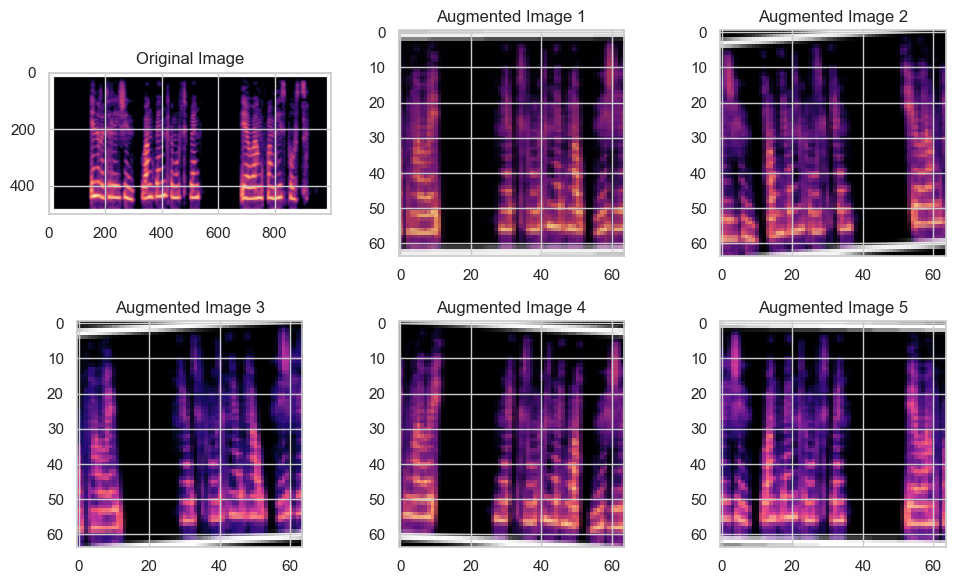

In [106]:
def choose_random_image(image_directory):
    """
    Returns a randomly selected image path from the given directory.

    Args:
        image_directory (str): Path to the directory containing images.

    Returns:
        str: Path to the randomly selected image.
    """
    images = [img for img in os.listdir(image_directory) if img.endswith(("jpg", "png", "jpeg"))]
    if not images:
        raise ValueError("No images found in the directory.")
    return os.path.join(image_directory, random.choice(images))

image_directory = "mel_spectrogram_images"
random_image_path = choose_random_image(image_directory)

# Loading the selected image
sample_image = Image.open(random_image_path)

# Defining the argumented data and applying transformations to them
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomResizedCrop(size=64, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
])

# Generating 5 augmented images with one image
augmented_images = [data_transforms(sample_image) for _ in range(5)]

# Ploting the original and augmented images
plt.figure(figsize=(10, 6))
plt.subplot(2, 3, 1)
plt.imshow(sample_image)
plt.title('Original Image')

for i, augmented_image in enumerate(augmented_images, start=2):
    plt.subplot(2, 3, i)
    plt.imshow(augmented_image)
    plt.title(f'Augmented Image {i-1}')

plt.tight_layout()
plt.show()